# Telecom Churn Prediction - Starter Notebook


# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [8]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)
data = pd.read_csv("/content/sample_data/train.csv")
unseen = pd.read_csv("/content/sample_data/test.csv")
sample = pd.read_csv("/content/sample_data/sample.csv")
data_dict = pd.read_csv("/content/sample_data/data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example:

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [10]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables.

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [11]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             'churn_probability']

data = data[variables].set_index('id')

In [ ]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Let's look at each variable's datatype:

In [12]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

Let's also summarize the features using the df.describe method:

In [13]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [17]:
data['circle_id'].unique()

array([109])

In [19]:
X = data.drop(['circle_id'], axis=1).iloc[:,:-1]
# Change '1' to 'axis=1' to specify the axis for dropping columns
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [21]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
20393,330,530,520,252.08,306.86,440.38,241.76,289.41,406.41,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,3104
45078,141,458,30,134.01,1276.88,0.00,63.99,231.83,5.71,0.0,...,0.0,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,730
19707,320,330,130,372.61,254.56,123.66,356.71,247.76,119.59,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,202
23142,298,270,371,302.09,185.84,234.18,260.91,164.41,197.64,0.0,...,0.6,2.8,22.47,0.0,0.0,0.0,43.24,283.77,231.71,724
45989,220,110,130,114.93,131.91,183.64,92.61,115.46,153.26,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,3105


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

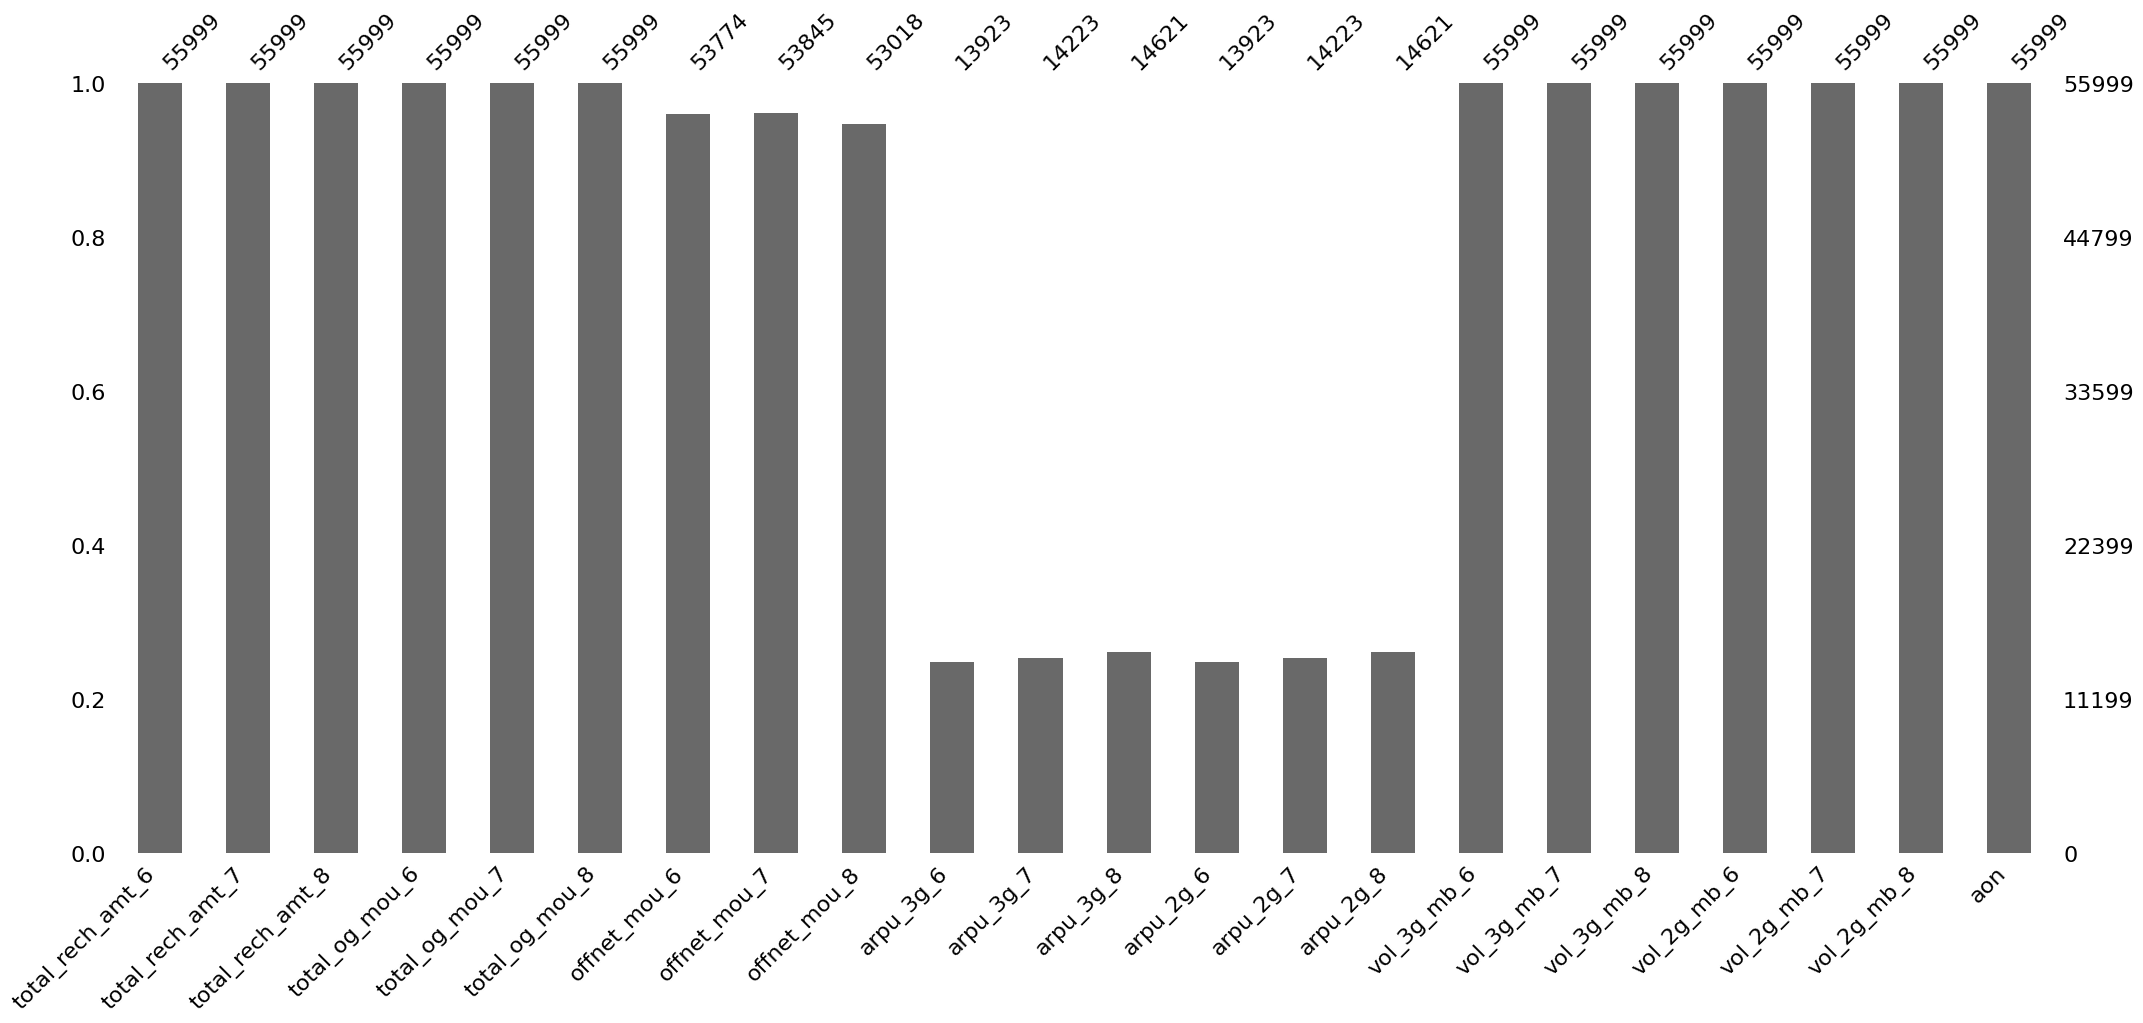

In [22]:
msno.bar(X_train)

<Axes: >

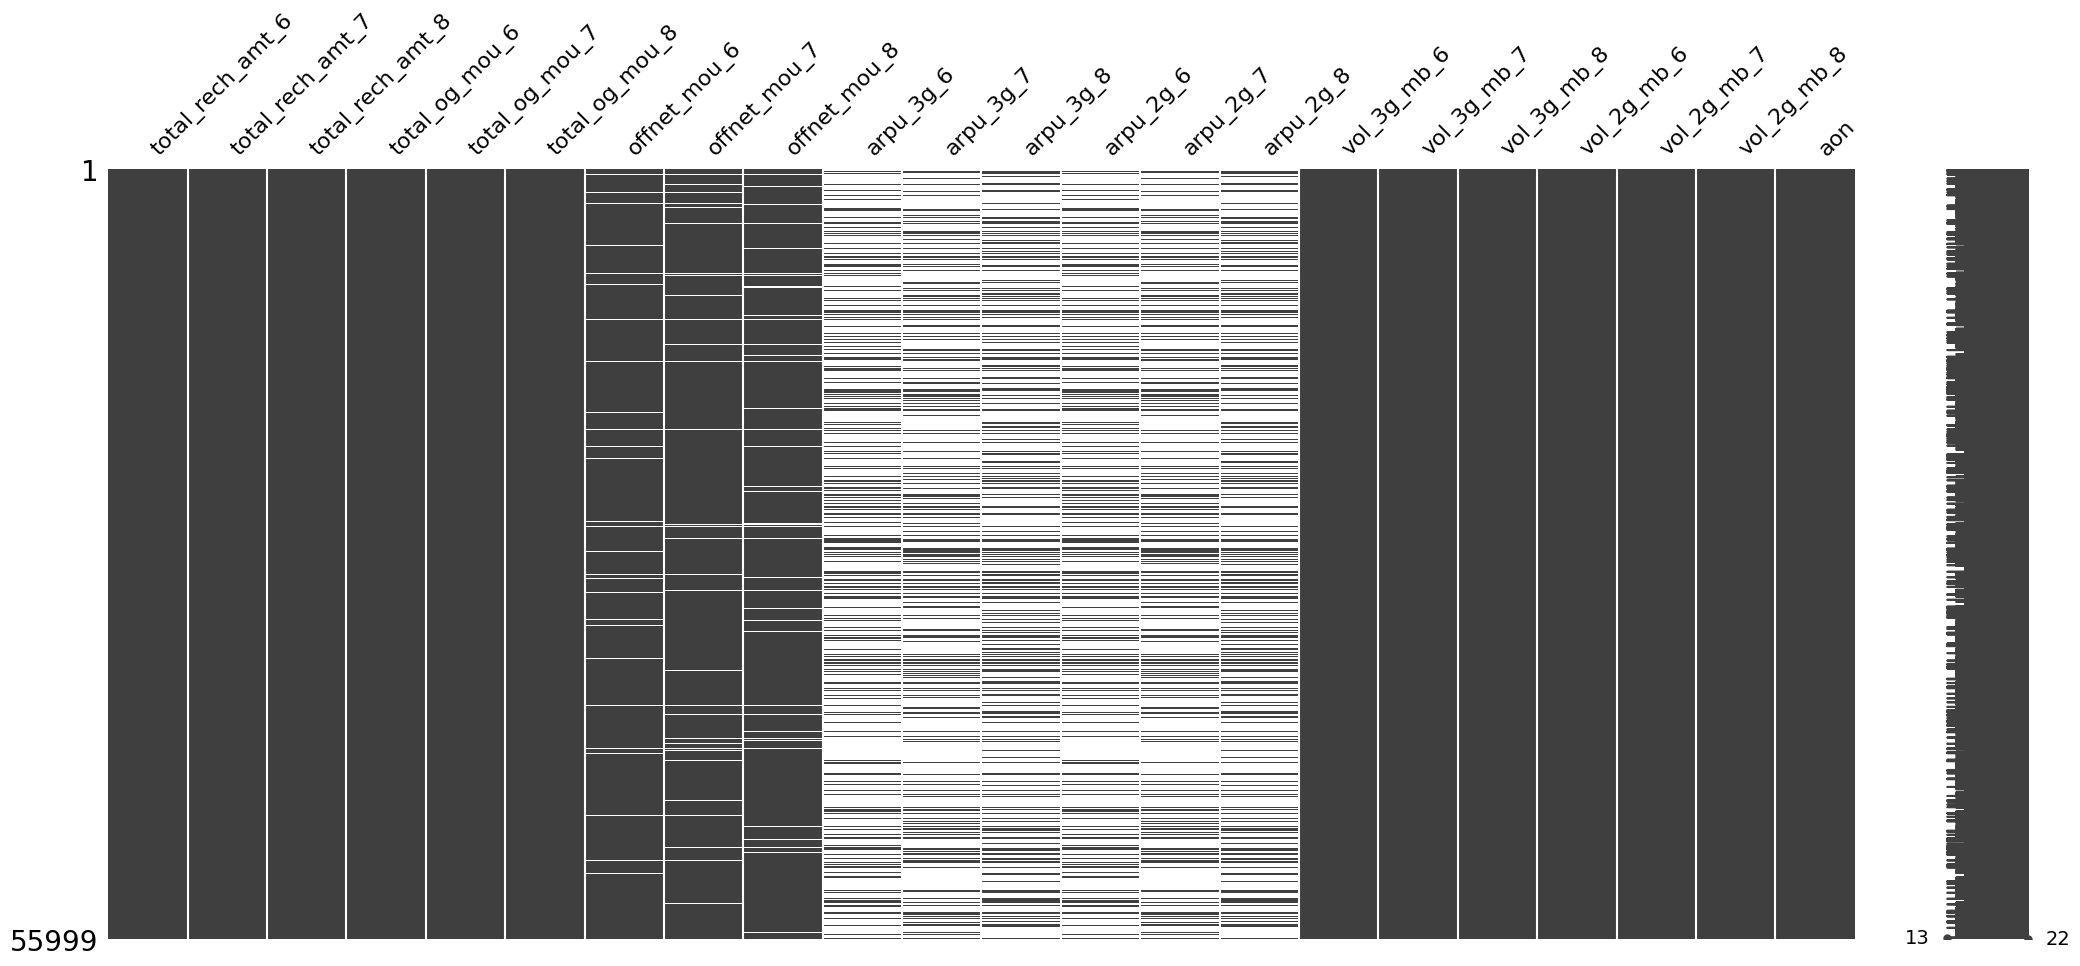

In [23]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [24]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

,0
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_og_mou_6,0.000000
total_og_mou_7,0.000000
total_og_mou_8,0.000000
offnet_mou_6,3.973285
offnet_mou_7,3.846497
offnet_mou_8,5.323309
arpu_3g_6,75.137056


Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [25]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [26]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 16)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data -

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [27]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [28]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

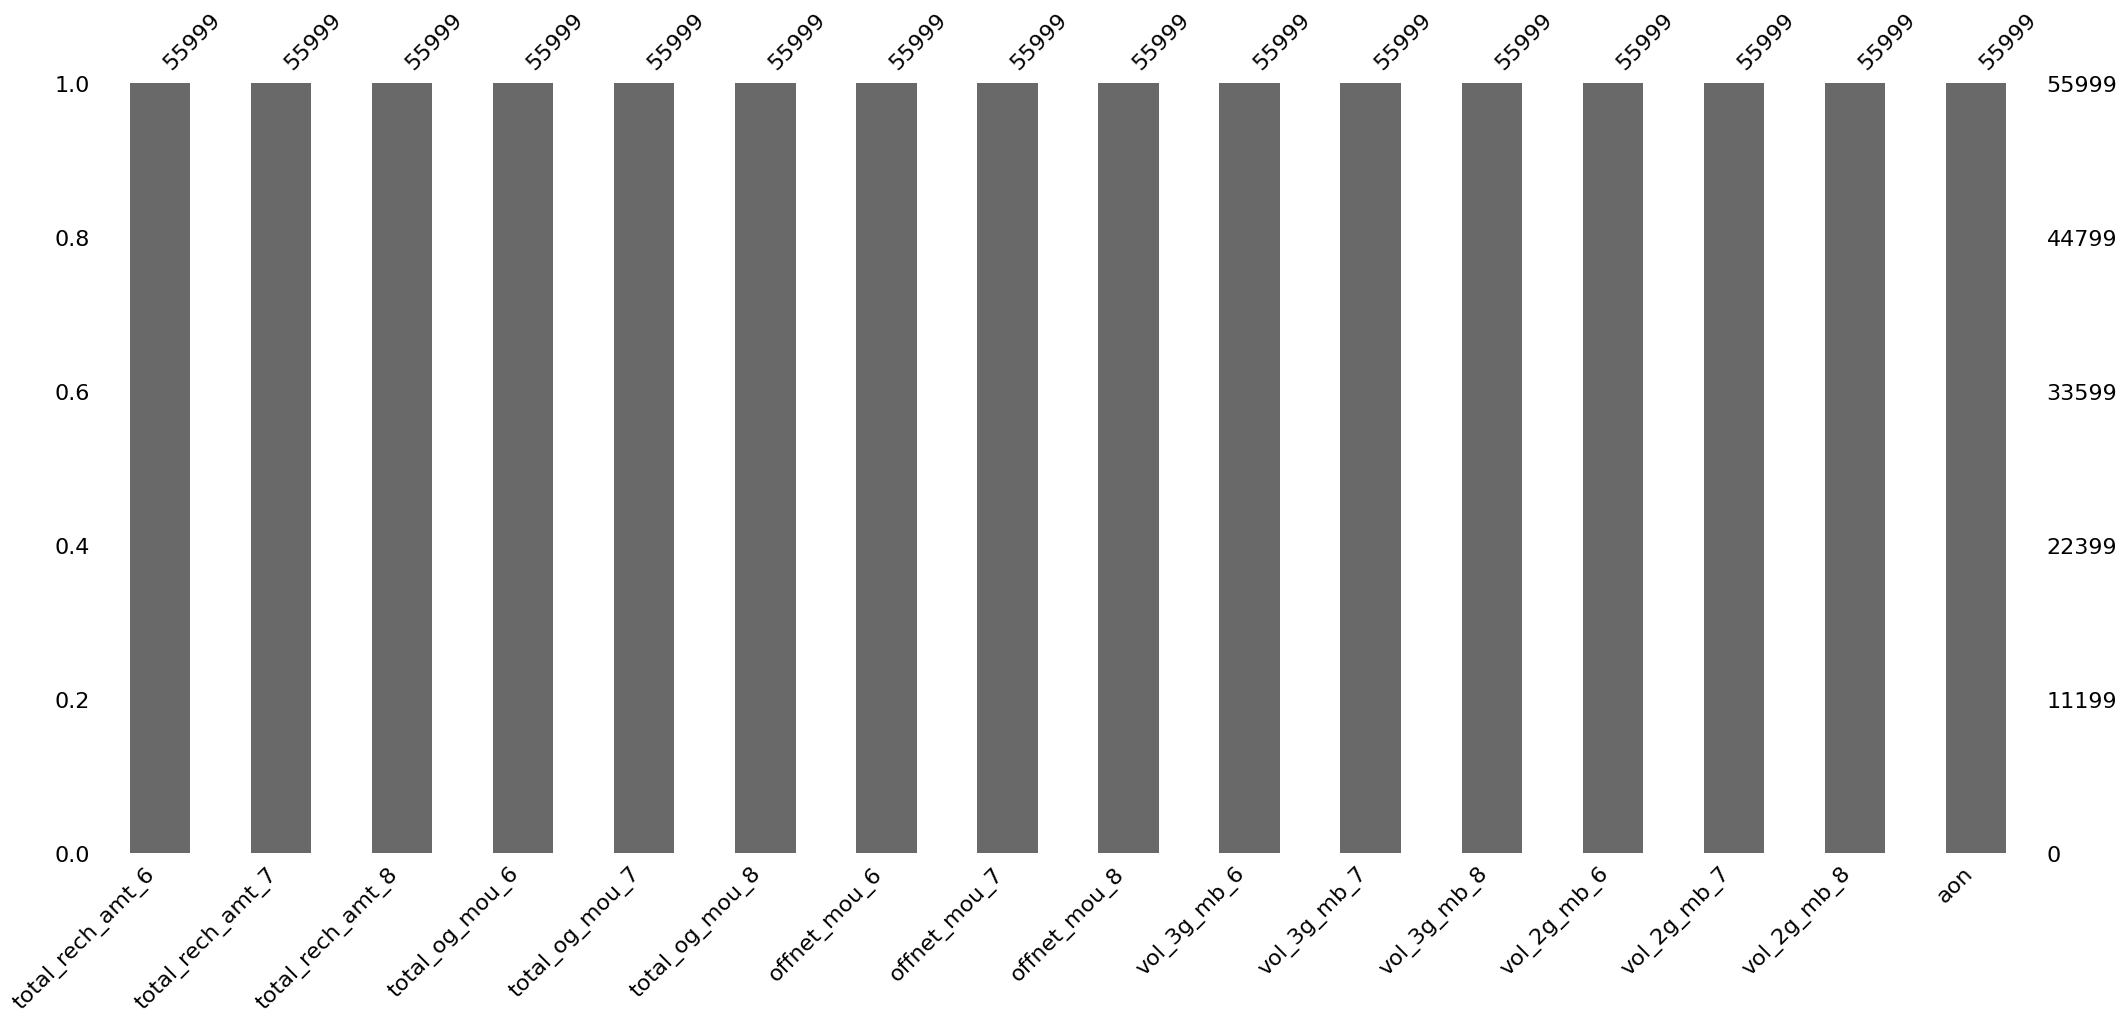

In [29]:
msno.bar(X_train_filtered)

In [30]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,327.276273,321.411936,322.022143,305.814719,309.708086,304.145912,190.158584,188.553069,185.684976,119.806905,127.694018,133.854435,51.261470,50.736473,49.874126,1220.796782
std,385.619162,386.088207,394.955506,465.443439,477.991306,480.728704,312.027371,318.242742,320.999793,520.453327,545.505404,563.075381,211.406075,211.637898,215.205373,952.307161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,110.000000,100.000000,90.000000,44.940000,42.660000,38.385000,28.770000,26.540000,23.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.000000
50%,228.000000,220.000000,223.000000,145.460000,140.710000,137.530000,89.890000,85.430000,82.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,870.000000
75%,436.000000,429.000000,433.000000,372.070000,378.220000,368.765000,222.200000,216.670000,215.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1814.000000
max,17840.000000,19204.000000,20405.000000,10674.030000,8157.510000,14043.060000,8362.360000,7043.980000,14007.340000,25692.060000,28144.120000,29651.830000,10285.900000,7873.550000,11117.610000,4337.000000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

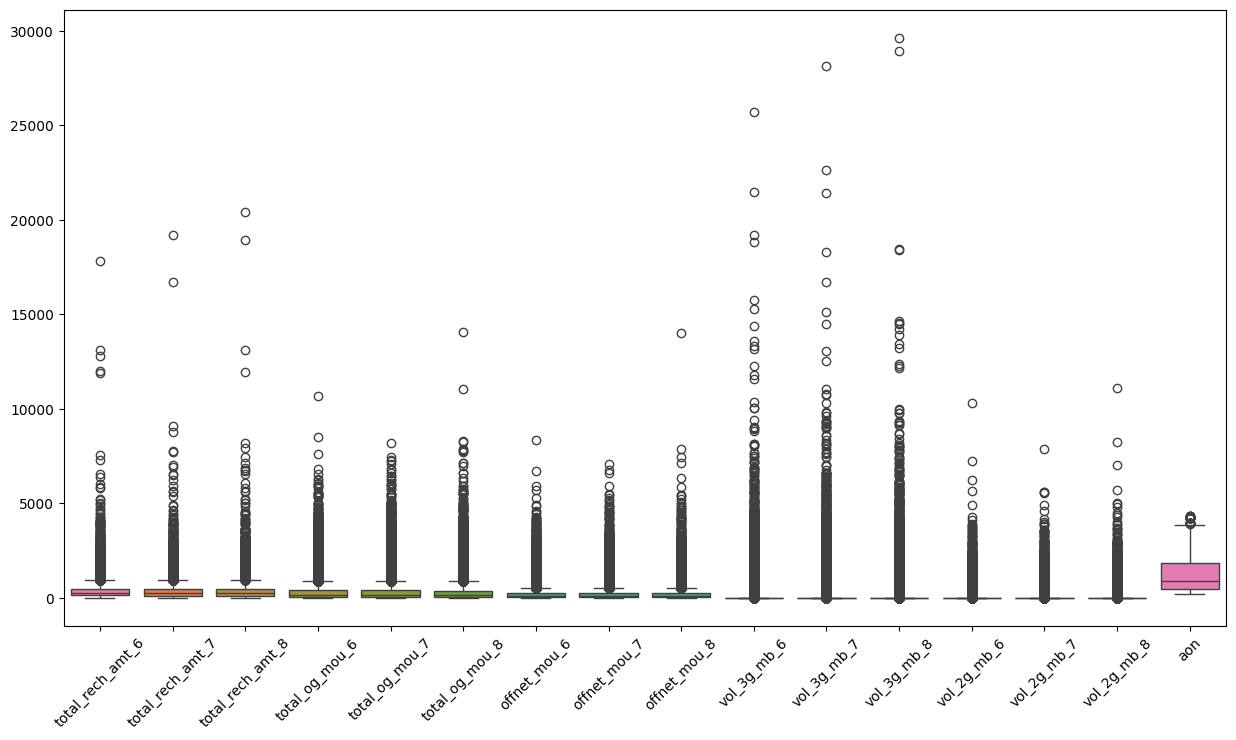

In [31]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [32]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

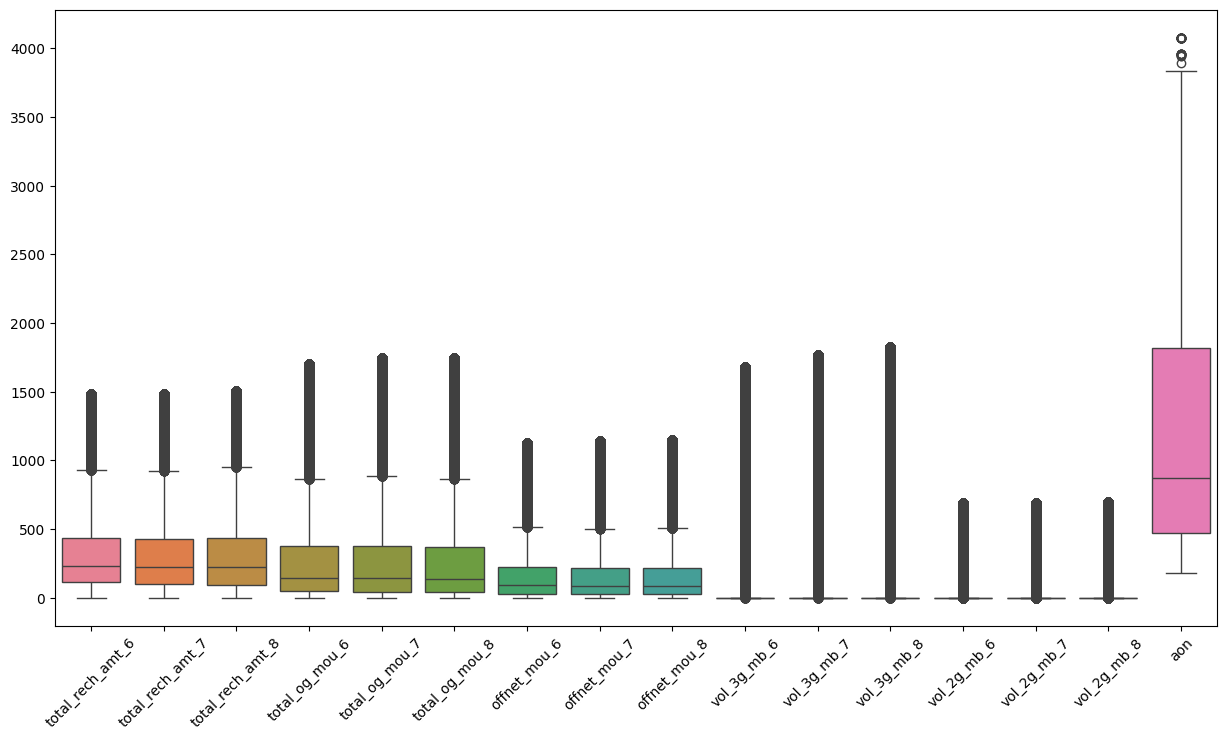

In [33]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [34]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

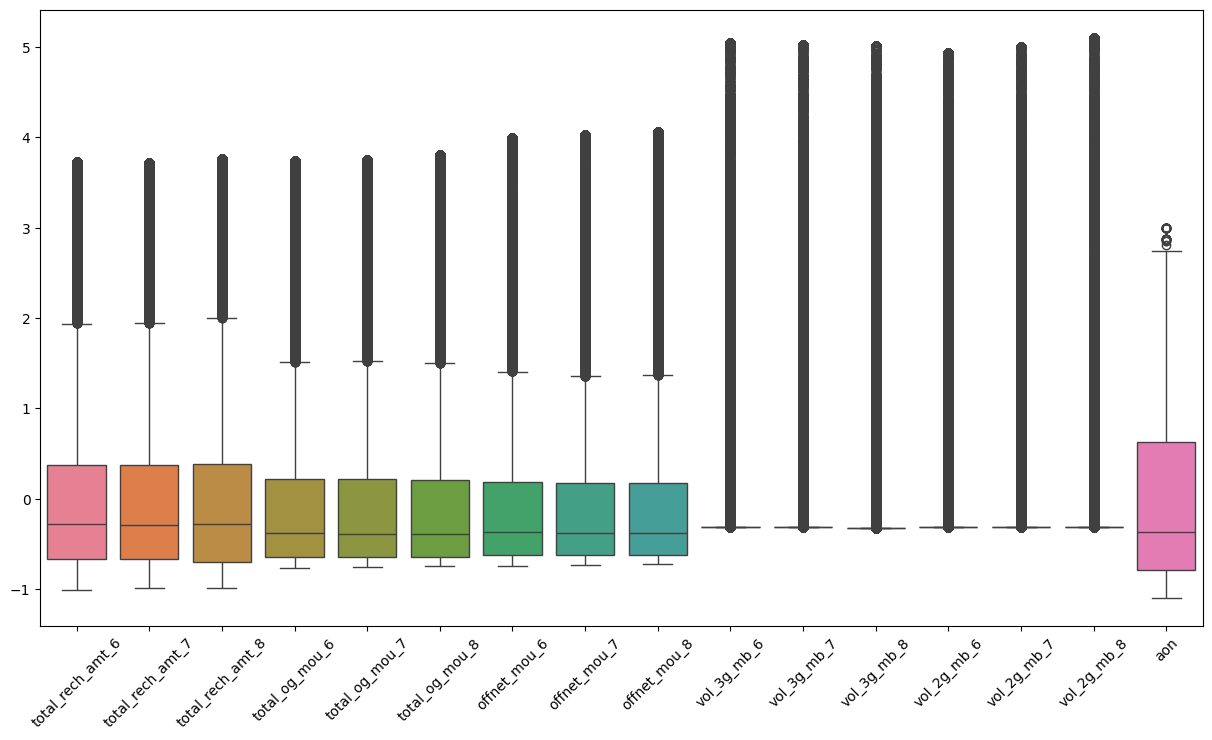

In [35]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage.

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.



<Axes: >

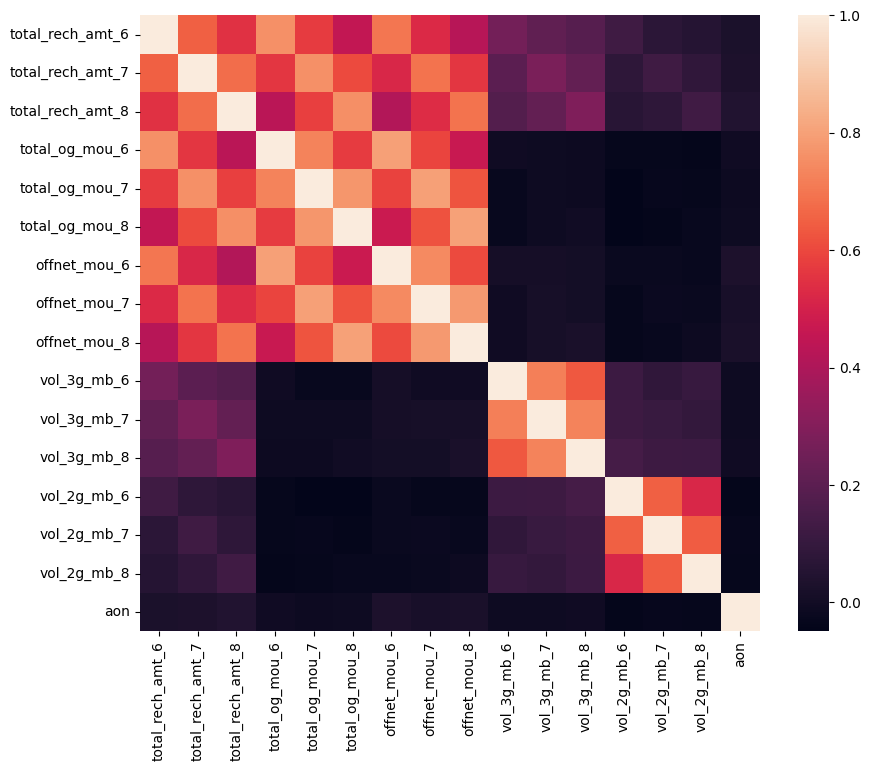

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

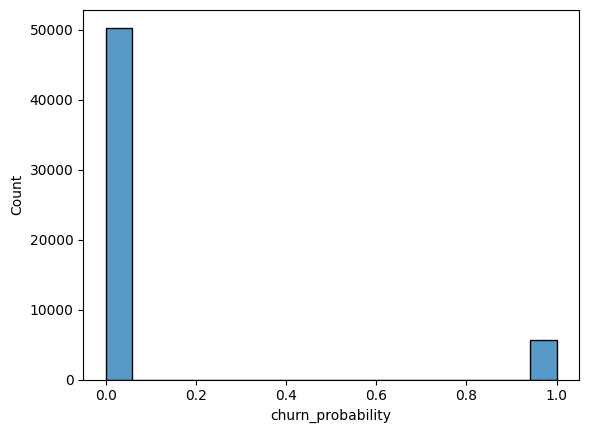

In [37]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [38]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [40]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 16 artists>

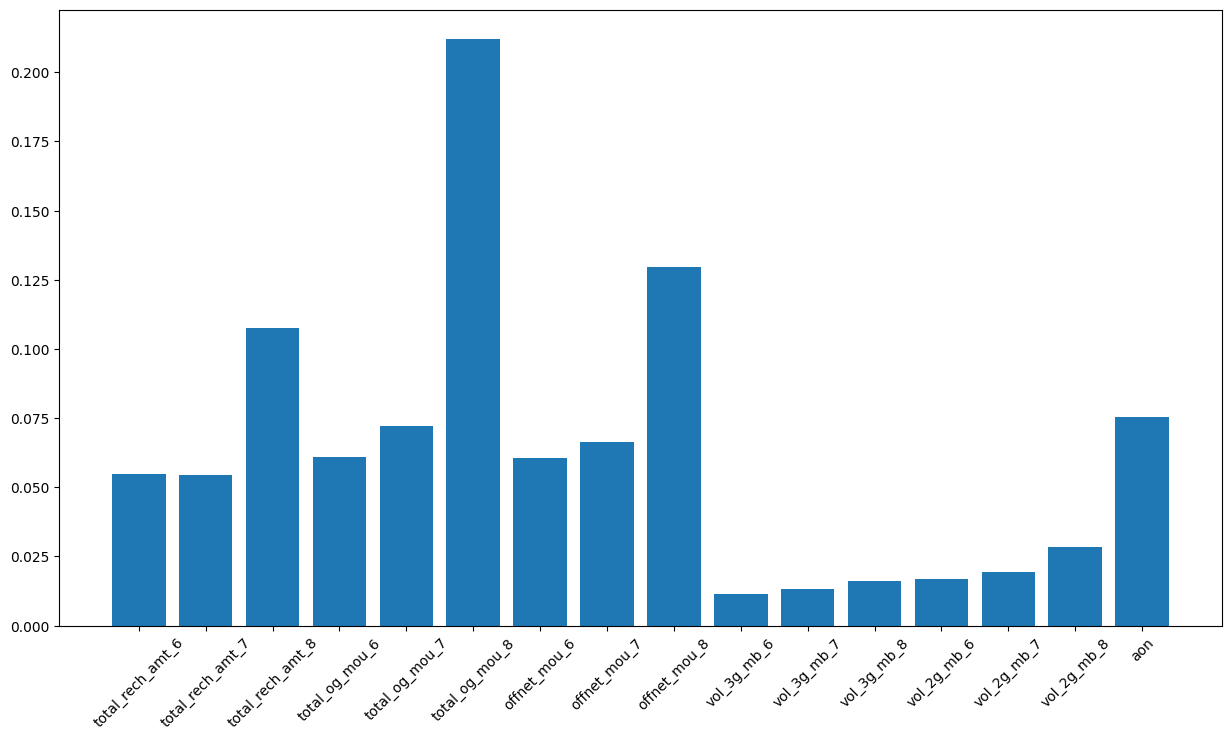

In [41]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)


<Axes: >

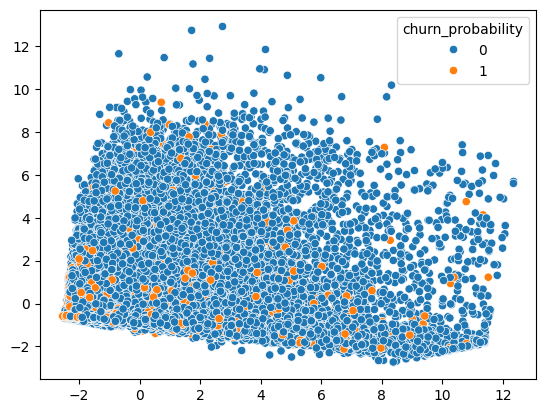

In [42]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

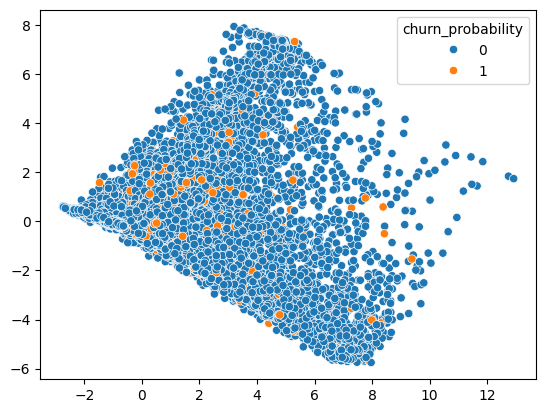

In [43]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 16 artists>

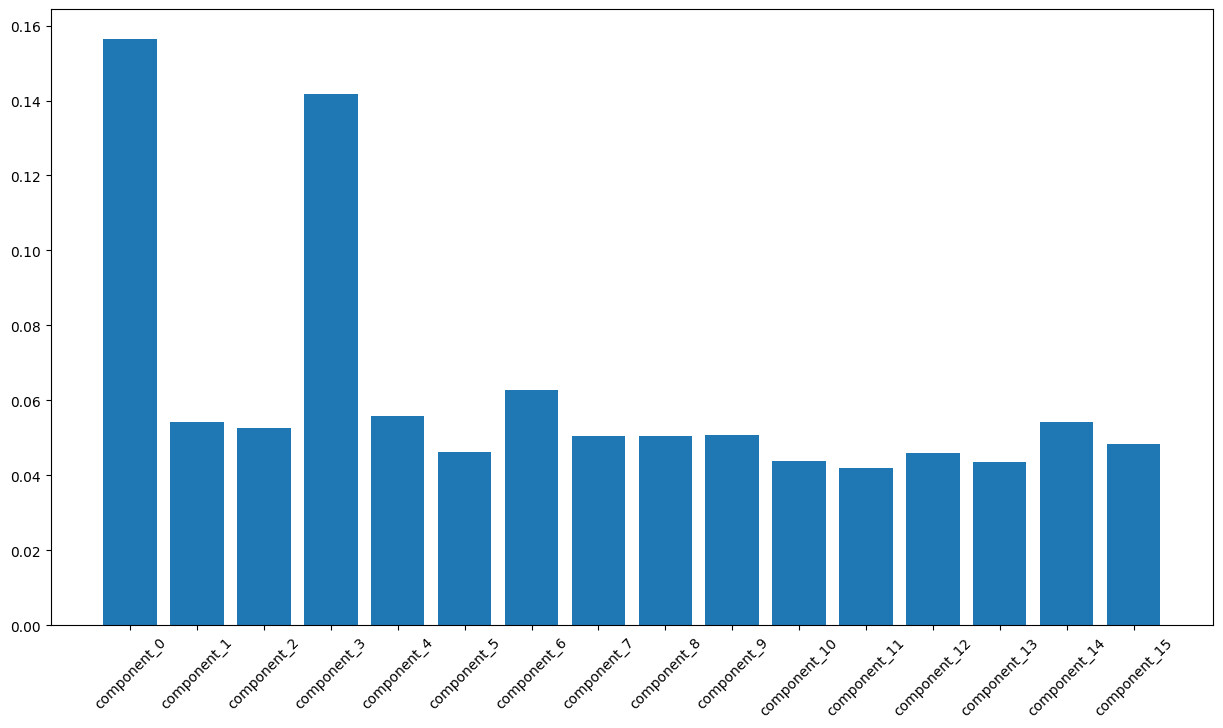

In [44]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)],
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [45]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [46]:
lr.score(pca_components[:,:2], y_train)

0.8985874747763353

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [47]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [48]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [49]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [50]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9005339381060377


In [51]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8987857142857143


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [52]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50038,   282],
       [ 5288,   391]])

In [53]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12480,    67],
       [ 1350,   103]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [54]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.6058823529411764

In [55]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.07088781830695114

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [56]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [57]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [58]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [59]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['churn_probability']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'churn_probability'}, axis=1)
              .sort_values('churn_probability', ascending=True))
  xs = counted['churn_probability']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('churn_probability', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('churn_probability')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [60]:
output.to_csv('submission.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.

In [61]:

from xgboost import XGBClassifier

# Create a new pipeline with XGBoost
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
pipe = Pipeline(steps=[('imputation', imp), ('scaling', scale), ('pca', pca),
                        ('model', xgb)])

# Perform hyperparameter tuning using GridSearchCV
param_grid = {'model__n_estimators': [50, 100, 200],
              'model__learning_rate': [0.01, 0.1, 0.2],
              'model__max_depth': [3, 5, 7]}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train[new_vars], y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
test_score = best_model.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

# Predict churn probability for the submission dataset
unseen['churn_probability'] = best_model.predict(submission_data)
output = unseen[['id', 'churn_probability']]
output.to_csv('submission.csv', index=False)




Test accuracy: 0.9126428571428571


In [66]:
X_train_filtered.describe()


,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,317.221332,311.217206,312.024781,289.547589,292.880601,287.303857,177.824414,176.001632,173.563425,97.608368,104.544936,110.290615,40.990388,40.111174,39.509488,1220.712301
std,313.319408,314.424696,317.242878,377.462979,386.465030,383.658553,237.396841,240.427415,239.924703,313.560819,330.304956,341.675297,130.668132,128.962641,128.456734,952.047087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,110.000000,100.000000,90.000000,44.940000,42.660000,38.385000,28.770000,26.540000,23.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.000000
50%,228.000000,220.000000,223.000000,145.460000,140.710000,137.530000,89.890000,85.430000,82.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,870.000000
75%,436.000000,429.000000,433.000000,372.070000,378.220000,368.765000,222.200000,216.670000,215.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1814.000000
max,1484.133759,1479.676558,1506.888661,1702.145036,1743.682004,1746.332026,1126.240698,1143.281296,1148.684355,1681.166886,1764.210231,1823.080579,685.479695,685.650167,695.490244,4077.718264


In [72]:
# prompt: Change columns and check churn probability using X_train_filtered  to achive 95%

# ... (Previous code) ...

# 1. Feature Selection:
# ... (Previous code) ...

# Example:
important_features = feature_importances.sort_values('importance', ascending=False).head(10)['col'].tolist()
# Instead of using X_train_filtered directly, create a new DataFrame with PCA-transformed features
X_train_pca = pipe[:-1].transform(X_train_filtered)  # Apply imputation, scaling, and PCA
X_train_pca = pd.DataFrame(X_train_pca, columns=['component_' + str(i) for i in range(X_train_pca.shape[1])])  # Name columns appropriately
X_train_selected = X_train_pca[important_features]

# ... (Rest of the code) ...

# 5. Train and Evaluate:
# ... (Previous code) ...

# Assuming 'pipe' is your pipeline with GradientBoostingClassifier
pipe.fit(X_train_selected, y_train)
train_score = pipe.score(X_train_selected, y_train)
print("Training accuracy:", train_score)

# Apply imputation, scaling, and PCA to X_test before selecting features
X_test_pca = pipe[:-1].transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca, columns=['component_' + str(i) for i in range(X_test_pca.shape[1])])
test_score = pipe.score(X_test_pca[important_features], y_test)
print("Test accuracy:", test_score)

# ... (Rest of the code) ...

NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [63]:
# prompt: run the model of test date

# Assuming 'best_model' is your trained model from the previous code
y_pred = best_model.predict(X_test[new_vars])

# Evaluate the model on the test data
test_score = best_model.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

# You can also print other metrics like confusion matrix, precision, recall, etc.
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Test accuracy: 0.9126428571428571
Confusion Matrix:
 [[12308   239]
 [  984   469]]
Precision: 0.6624293785310734
Recall: 0.32278045423262214
